In [1]:
# Importing all the libraries
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read the data
base_skin_dir ="/content/drive/MyDrive/Skin_Disease_Classification_dataset"
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham1000"'*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [4]:
data=pd.read_csv("/content/drive/MyDrive/Skin_Disease_Classification_dataset/HAM10000_metadata.csv")

In [5]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
data.describe(exclude=[np.number]) # Tells about total count of every columns like we have total 7 unique classes.

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [7]:
data.isnull().any().sum()

1

In [8]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)
data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...


In [9]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64)))) # open the image and resize it to (64,64) and add to image_pixel.
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


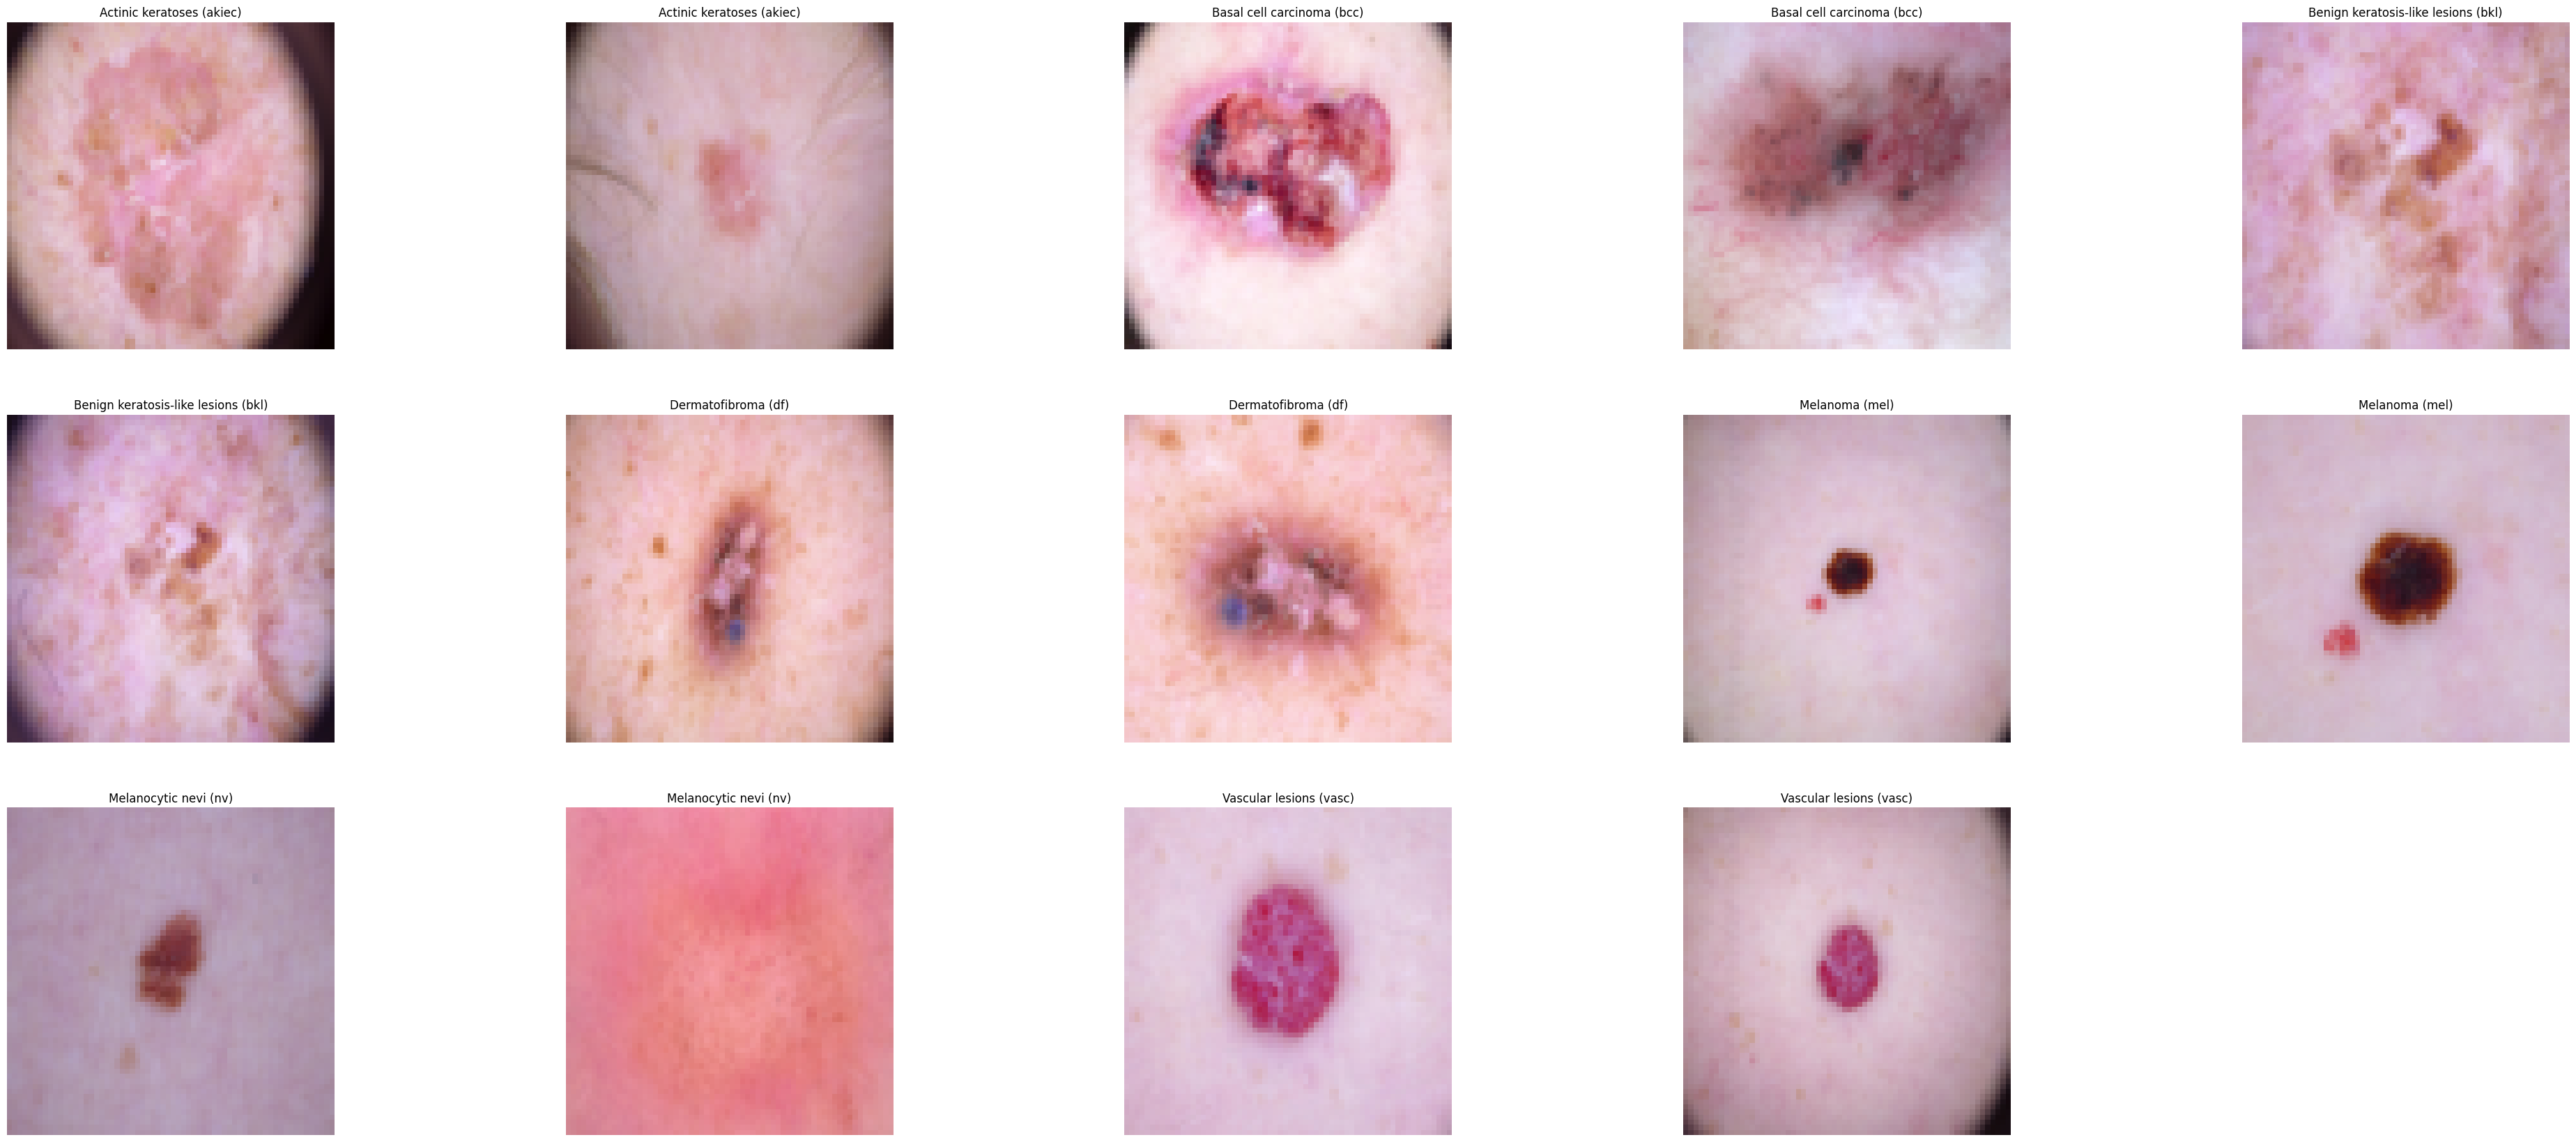

In [10]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(50,50))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [11]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [12]:
data.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[237, 160, 172], [239, 161, 174], [240, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[215, 105, 131], [221, 116, 135], [225, 124,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[233, 130, 150], [235, 136, 156], [238, 141,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[215, 121, 155], [214, 118, 154], [214, 122,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/content/drive/MyDrive/Skin_Disease_Classifica...,"[[[233, 141, 164], [234, 145, 168], [235, 147,...",0


To Balance the dataset

In [13]:
counter = 0
frames = [data] # # store the data frames
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values # retrieves the indices where the 'label' column in the 'data' DataFrame matches the current 'counter' value
    df_index = data.iloc[int(min(index)):int(max(index)+1)] #selects the corresponding rows from 'data' using the retrieved indices.
    df_index = df_index.append([df_index]*i, ignore_index = True)  # it appends a copy of the selected rows to the 'df_index' DataFrame 'i' times
    frames.append(df_index)

<ipython-input-13-312b5f4afd2c>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index = df_index.append([df_index]*i, ignore_index = True)  # it appends a copy of the selected rows to the 'df_index' DataFrame 'i' times


In [14]:
len(frames)

7

In [15]:
for df in frames:
  print(df)

       index    lesion_id      image_id  dx    dx_type  age     sex  \
0       5007  HAM_0006322  ISIC_0030309  nv  follow_up   55    male   
1       4478  HAM_0003084  ISIC_0026191  nv  follow_up   45  female   
2       4477  HAM_0002093  ISIC_0027032  nv  follow_up   45  female   
3       4476  HAM_0003701  ISIC_0027191  nv  follow_up   45  female   
4       4475  HAM_0003806  ISIC_0028667  nv  follow_up   45  female   
...      ...          ...           ...  ..        ...  ...     ...   
10010   1175  HAM_0003597  ISIC_0033422  df  consensus   45    male   
10011   1176  HAM_0003597  ISIC_0027488  df  consensus   45    male   
10012   1177  HAM_0003081  ISIC_0033808  df  consensus   45    male   
10013   1179  HAM_0003081  ISIC_0033860  df  consensus   45    male   
10014   1123  HAM_0004317  ISIC_0025504  df      histo   50  female   

          localization              cell_type  \
0                 foot  Melanocytic nevi (nv)   
1      upper extremity  Melanocytic nevi (nv)   


In [16]:
final_data = pd.concat(frames)
print(data.shape) # unbalanced dataset
print(final_data.shape) # Balanced dataset

(10015, 12)
(45756, 12)


In [17]:
   # ORIGINAL DATA(Unbalanced)
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 64, 64, 3)
(10015, 1)


In [18]:
# AUGMENTED DATA(final data obtained from concatenating the frames(Balanced(each class has equal number of images)))
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 64, 64, 3)
(45756, 1)


In [20]:
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test_split(X_orig, Y_orig, test_size=0.2, random_state=1)

# Prepare data for training and testing the model
train_datagen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = 'nearest')
train_datagen.fit(X_train_orig)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test_orig)

In [21]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(X_aug, Y_aug, test_size=0.2, random_state=1)

# Prepare data for training and testing the model
train_datagen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = 'nearest')
train_datagen.fit(X_train_orig)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test_orig)

In [22]:

model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (64,64, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0006)

model.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = optimizer,
            metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

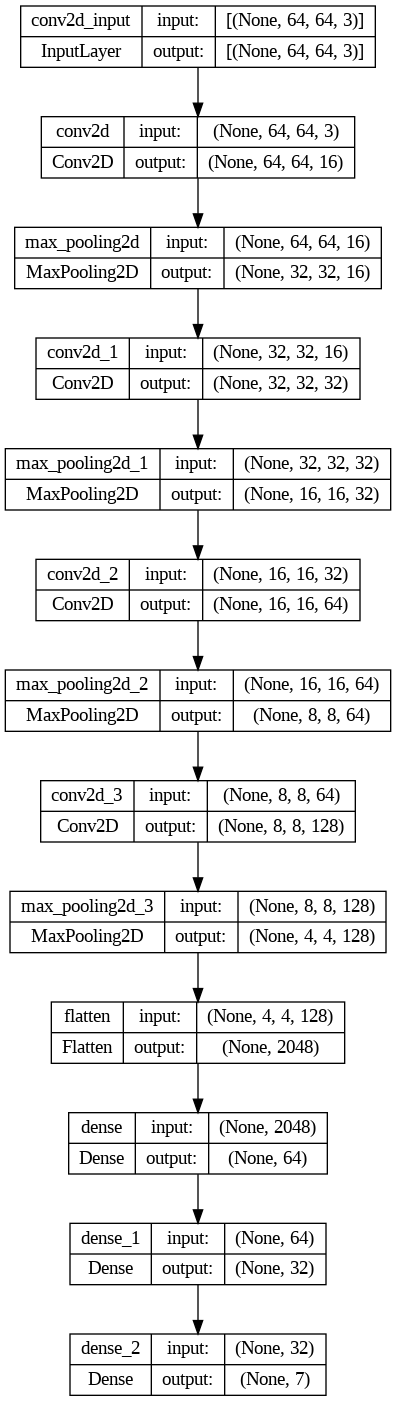

In [23]:

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)


In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto')
                               #, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                          verbose=1, mode='auto')

history = model.fit(X_train_aug,
                    Y_train_aug,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs=25,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/25
458/458 [==============================] - 17s 10ms/step - loss: 1.7556 - accuracy: 0.4706 - val_loss: 0.9953 - val_accuracy: 0.6166 - lr: 6.0000e-04
Epoch 2/25
458/458 [==============================] - 3s 7ms/step - loss: 0.8395 - accuracy: 0.6891 - val_loss: 0.7017 - val_accuracy: 0.7468 - lr: 6.0000e-04
Epoch 3/25
458/458 [==============================] - 3s 7ms/step - loss: 0.6243 - accuracy: 0.7726 - val_loss: 0.5557 - val_accuracy: 0.7961 - lr: 6.0000e-04
Epoch 4/25
458/458 [==============================] - 3s 7ms/step - loss: 0.4569 - accuracy: 0.8354 - val_loss: 0.5320 - val_accuracy: 0.8293 - lr: 6.0000e-04
Epoch 5/25
458/458 [==============================] - 4s 8ms/step - loss: 0.3169 - accuracy: 0.8912 - val_loss: 0.3546 - val_accuracy: 0.8693 - lr: 6.0000e-04
Epoch 6/25
458/458 [==============================] - 3s 7ms/step - loss: 0.2396 - accuracy: 0.9170 - val_loss: 0.2345 - val_accuracy: 0.9235 - lr: 6.0000e-04
Epoch 7/25
458/458 [========================

In [ ]:
model.save('skin_cancer.h5')

<Figure size 1000x400 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Number of Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Model Accuracy')

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Model Loss')

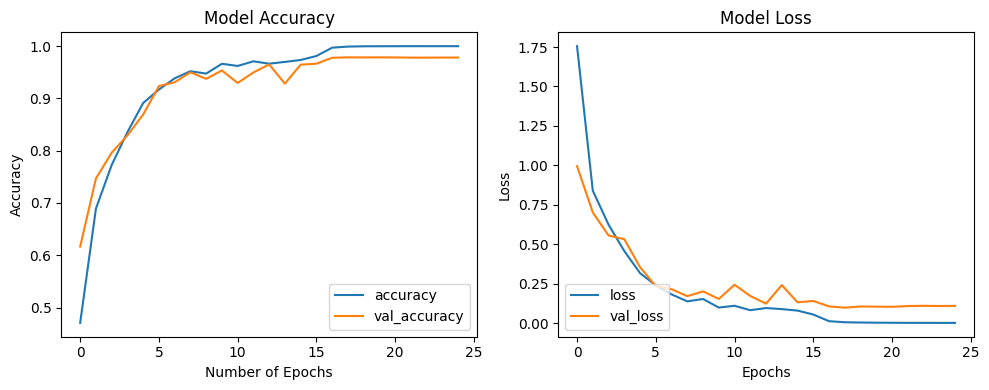

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

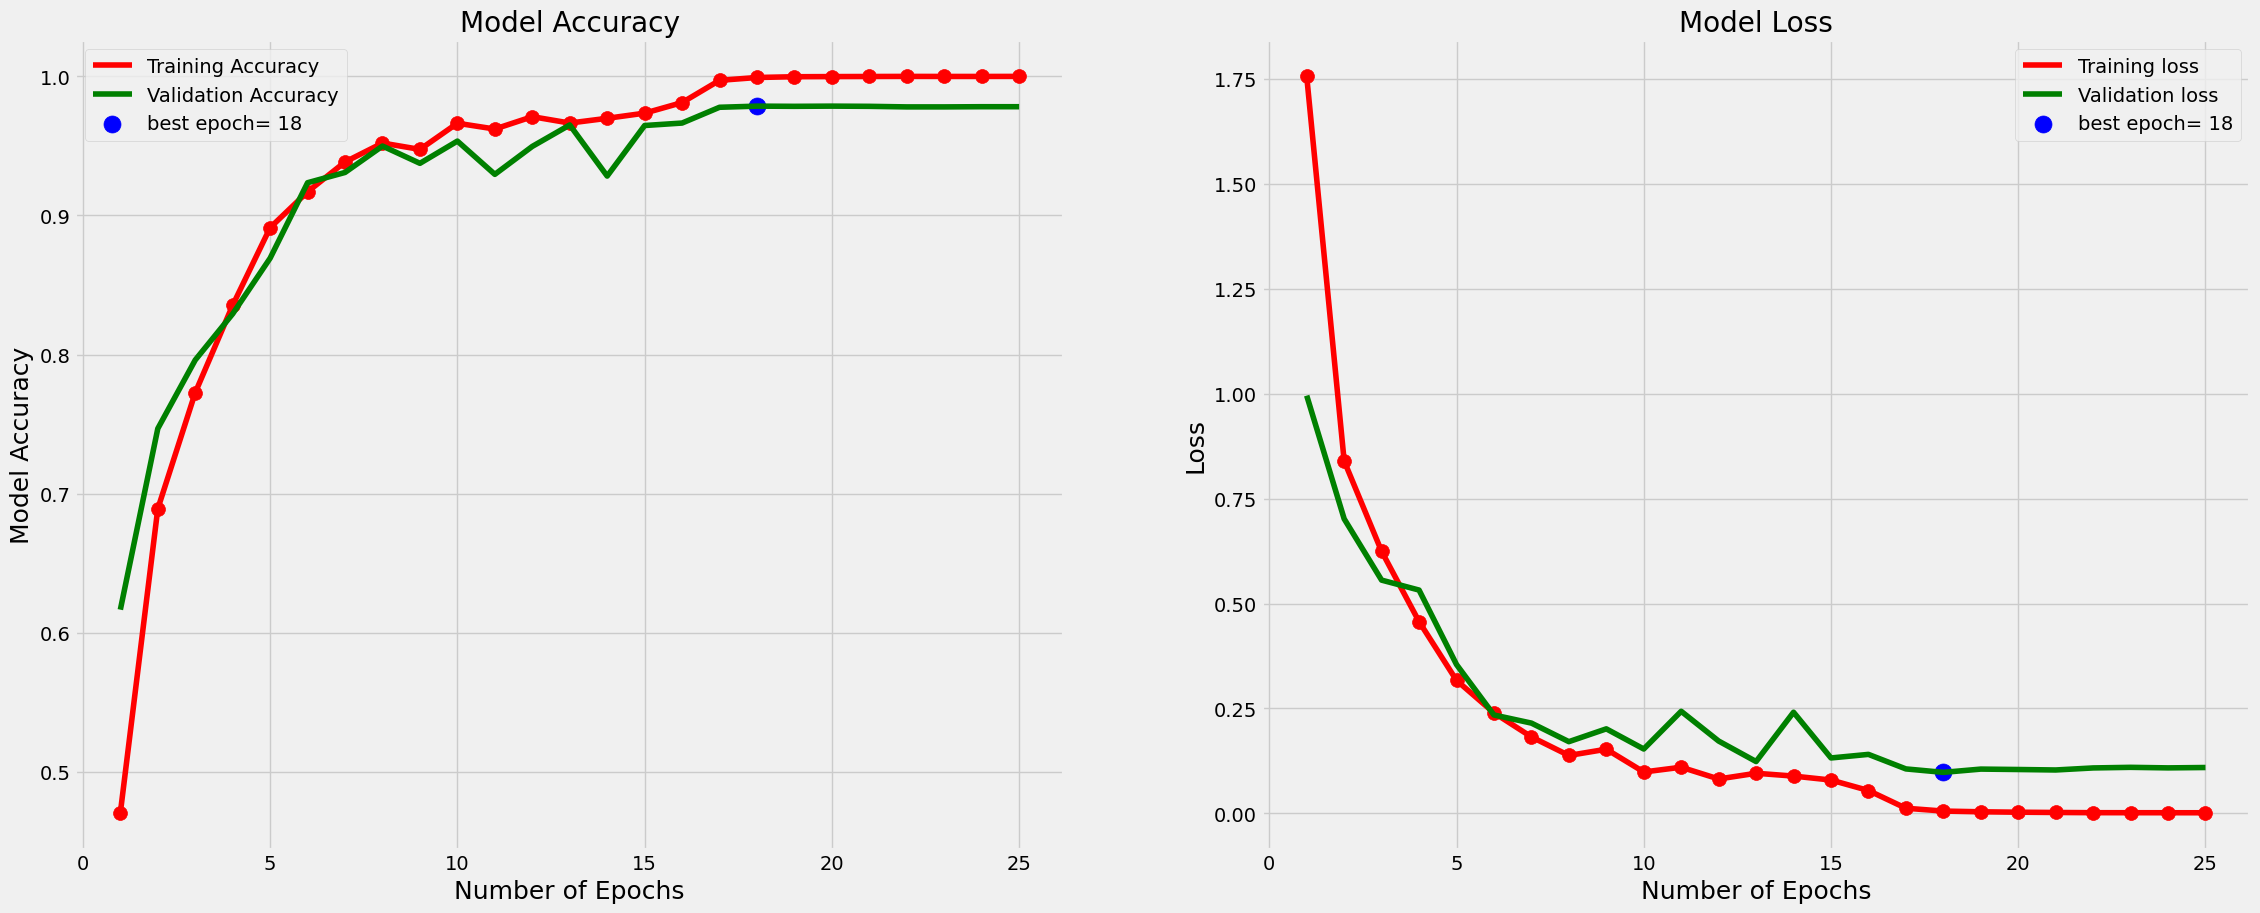

In [26]:
import numpy as np
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[1].plot(Epochs,tloss, 'r', label='Training loss')
    axes[1].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[1].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[1].scatter(Epochs, tloss, s=100, c='red')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Number of Epochs', fontsize=18)
    axes[1].set_ylabel('Loss', fontsize=18)
    axes[1].legend()
    axes[0].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[0].scatter(Epochs, tacc, s=100, c='red')
    axes[0].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[0].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Number of Epochs', fontsize=18)
    axes[0].set_ylabel('Model Accuracy', fontsize=18)
    axes[0].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(history,0)


Test Accuracy: 97.004%
63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

          nv       1.00      0.96      0.98      1374
         mel       0.87      0.99      0.92       205
         bkl       0.93      1.00      0.96       227
         bcc       0.95      1.00      0.97        94
       akiec       0.95      1.00      0.97        55
        vasc       0.97      1.00      0.98        28
          df       1.00      1.00      1.00        20

    accuracy                           0.97      2003
   macro avg       0.95      0.99      0.97      2003
weighted avg       0.97      0.97      0.97      2003



<Figure size 2200x1200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'bkl|bkl')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

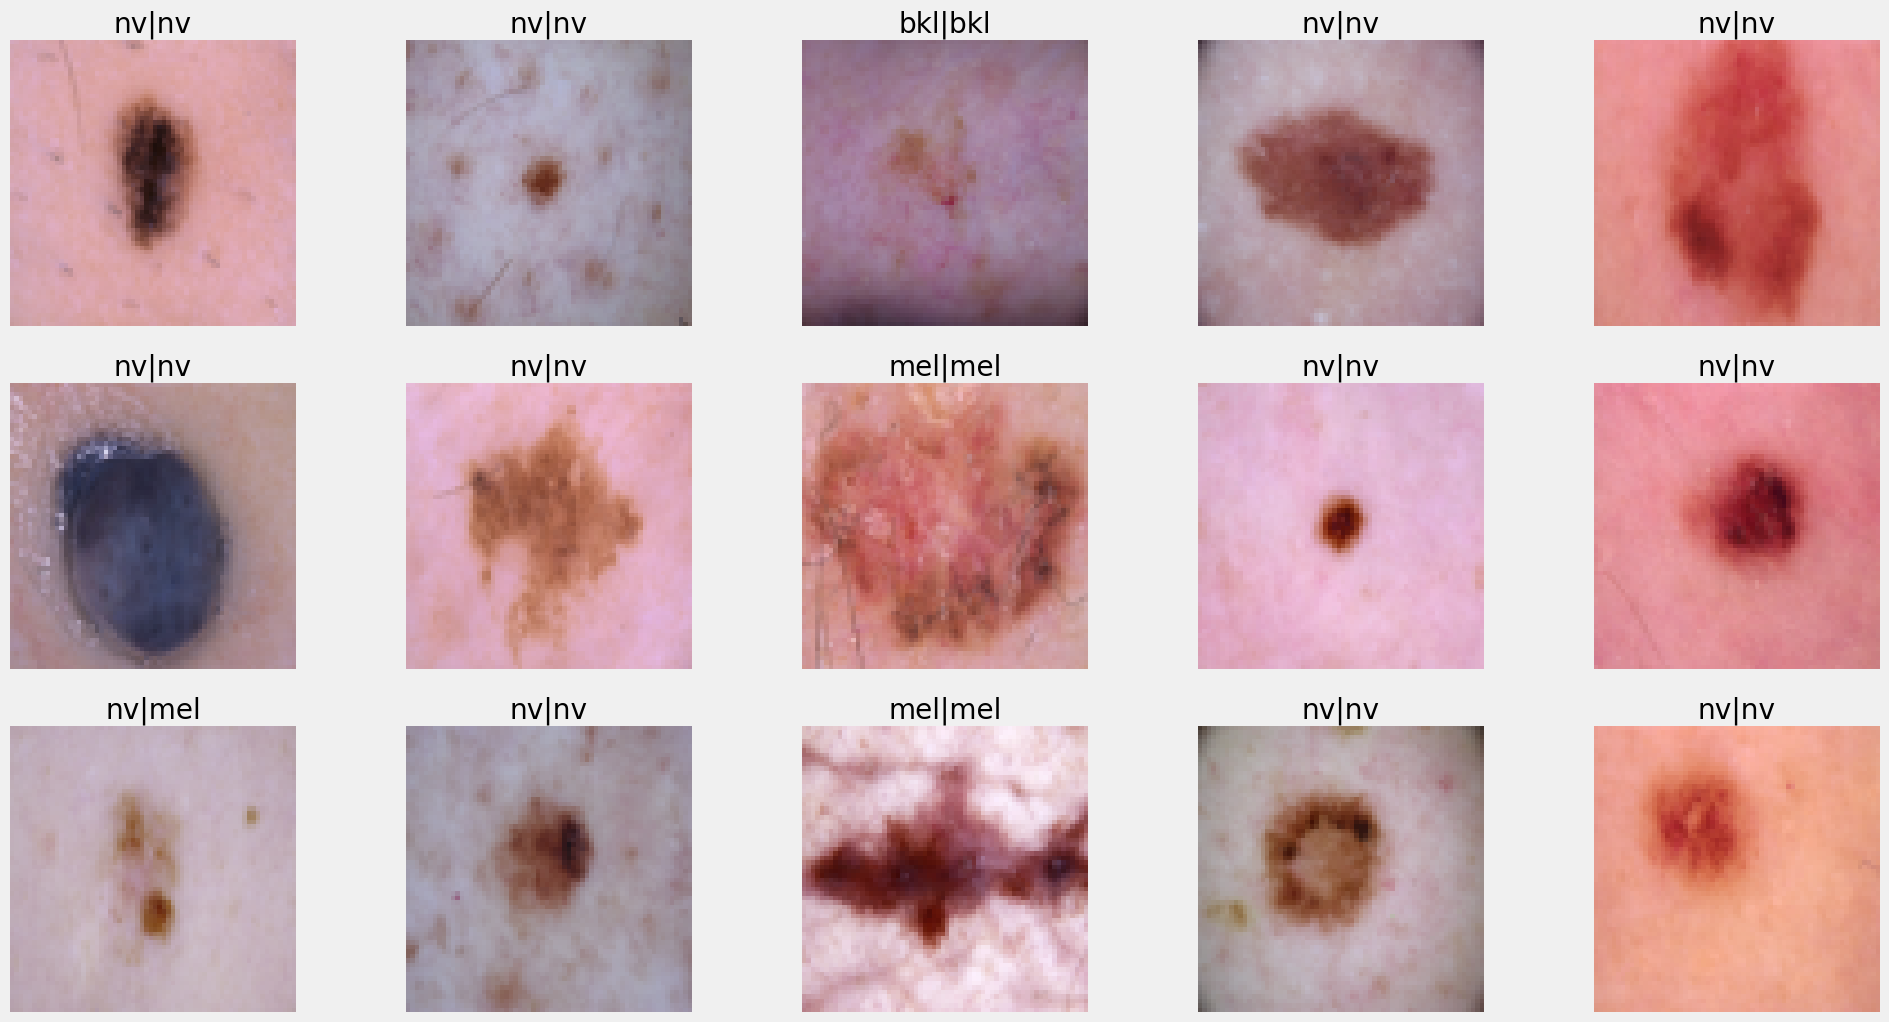

In [27]:
model_acc = model.evaluate(X_test_orig, Y_test_orig, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))
y_true = np.array(Y_test_orig)
y_pred = model.predict(X_test_orig)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
print(clr)

sample_data = X_test_orig[:15]
plt.figure(figsize=(22, 12))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_data[i])
    plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
    plt.axis("off")
plt.show()

Test Accuracy: 97.935%
286/286 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

          nv       0.99      0.88      0.93      1385
         mel       0.94      0.99      0.96      1328
         bkl       0.96      1.00      0.98      1294
         bcc       0.99      1.00      0.99      1325
       akiec       0.99      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



<Figure size 2200x1200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'vasc|vasc')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'vasc|vasc')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'bkl|bkl')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'df|df')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'nv|nv')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'bcc|bcc')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'bcc|bcc')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'bkl|bkl')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'akiec|akiec')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'mel|mel')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'bkl|bkl')

(-0.5, 63.5, 63.5, -0.5)

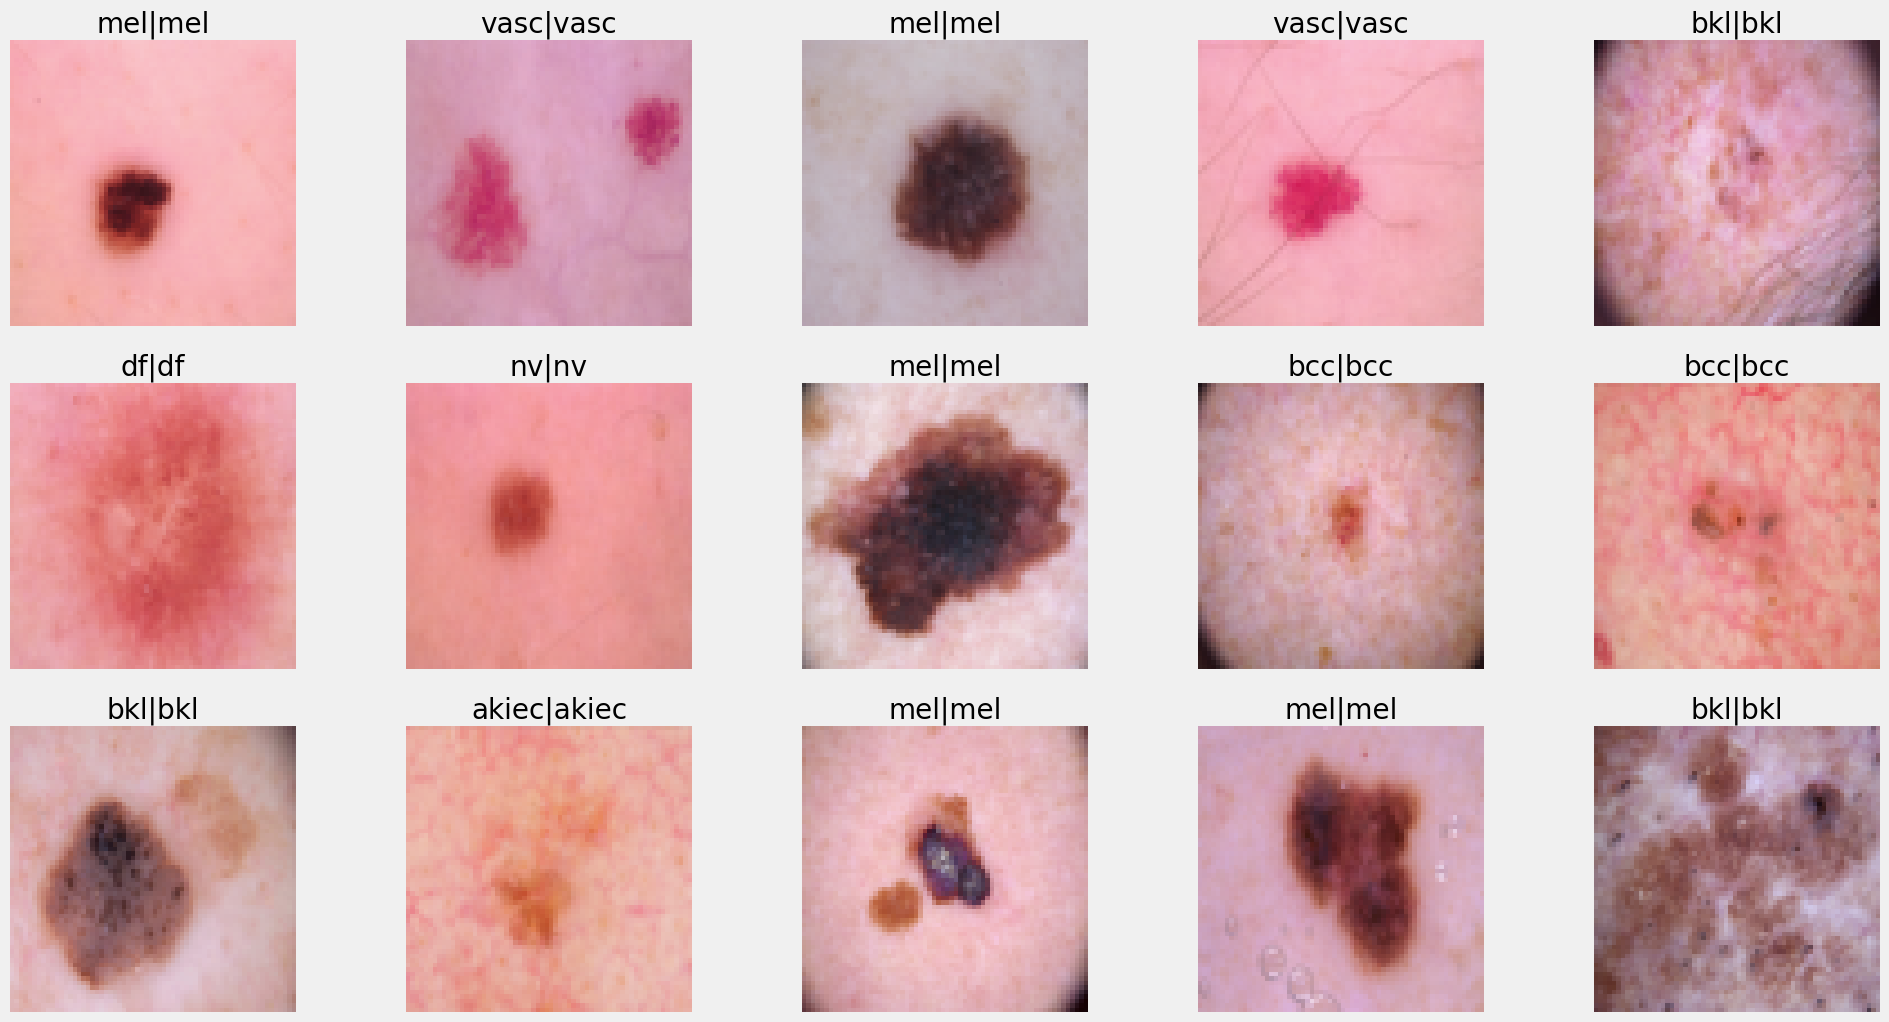

In [28]:
model_acc = model.evaluate(X_test_aug, Y_test_aug, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))
y_true = np.array(Y_test_aug)
y_pred = model.predict(X_test_aug)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
print(clr)

sample_data = X_test_aug[:15]
plt.figure(figsize=(22, 12))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_data[i])
    plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
    plt.axis("off")
plt.show()

In [29]:
y_true = np.array(Y_test_orig)
y_pred_orig = model.predict(X_test_orig)
y_pred_orig = np.array(list(map(lambda x: np.argmax(x), y_pred_orig)))
y_pred_orig

63/63 [==============================] - 0s 3ms/step


array([0, 0, 2, ..., 1, 0, 1])

Text(0.5, 5.583333333333313, 'Predicted Labels')

Text(10.58333333333333, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix using CNN on Original test data')

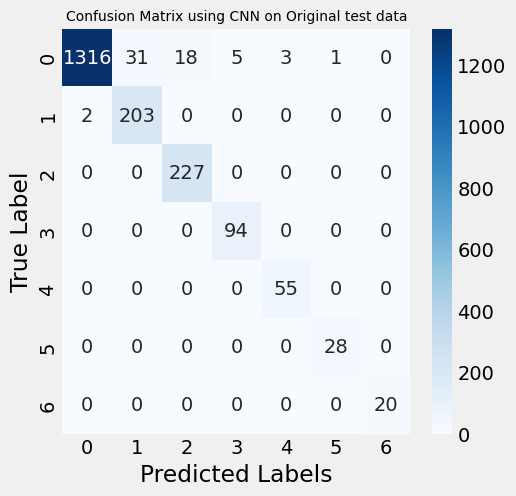

In [34]:
import seaborn as sns
confusion_mtx = confusion_matrix(Y_test_orig, y_pred_orig)

# visualize confusion matrix with matplotlib and seaborn
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix using CNN on Original test data",fontsize=10)

In [31]:
y_true = np.array(Y_test_aug)
y_pred_aug = model.predict(X_test_aug)
y_pred_aug = np.array(list(map(lambda x: np.argmax(x), y_pred_aug)))
y_pred_aug

286/286 [==============================] - 1s 2ms/step


array([1, 5, 1, ..., 4, 2, 2])

Text(0.5, 5.583333333333313, 'Predicted Labels')

Text(10.58333333333333, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix using CNN on Augumented test data')

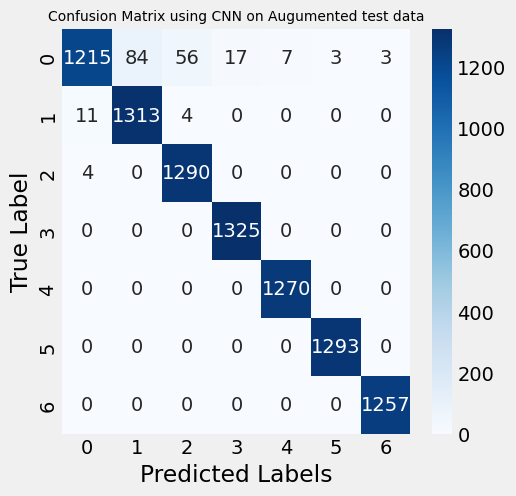

In [33]:
import seaborn as sns
confusion_mtx = confusion_matrix(Y_test_aug, y_pred_aug)

# visualize confusion matrix with matplotlib and seaborn
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix using CNN on Augumented test data",fontsize=10)